In [1]:
import numpy as np

import random
import h5py
from nn_util import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.initializers import *
import tensorflow

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = "Symbola"
matplotlib.rcParams['font.size'] = 12
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
import consts
consts.NBINS = 16
consts.BINS_INIT = np.linspace(-1.0, 1.0, consts.NBINS)
consts.QUANT_BINS = K.variable(consts.BINS_INIT, name = 'QUANT_BINS')
consts.QUANTIZATION_ON = K.variable(True, name = 'QUANTIZATION_ON')

In [4]:
# external custom code I wrote
from consts import *
from load_data import *
from windowing import *
from pesq import *
from nn_blocks import *
from perceptual_loss import *
from evaluation import *

In [5]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [6]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    np.random.seed(1337)
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

X_train = np.copy(train_processed)

(101750, 512, 1)
3.81413e-06
0.103483
-1.0
1.0


# Non-Adaptive Quantization

In [7]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (-1, NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    return entropy

def code_sparsity(placeholder, code):
    sparsity = K.mean(K.sum(K.sqrt(code + K.epsilon()), axis = -1), axis = -1) - 1.0
    return sparsity

In [8]:
input_dim = (WINDOW_SIZE, 1)

enc_input = Input(shape = input_dim)
enc = Reshape((WINDOW_SIZE, 1))(enc_input)
enc = Conv1D(1, 15, padding = 'same',
             kernel_initializer = Orthogonal(),
             activation = 'linear')(enc)
enc = SoftmaxQuantization()(enc)
enc = Model(inputs = enc_input, outputs = enc)

dec_input = Input(shape = (WINDOW_SIZE, NBINS))
dec = SoftmaxDequantization()(dec_input)
dec = Reshape((WINDOW_SIZE, 1))(dec)
dec = Conv1D(1, 15, padding = 'same',
             kernel_initializer = Orthogonal(),
             activation = 'linear')(dec)
dec = Model(inputs = dec_input, outputs = dec)

In [9]:
n_recons = 2
n_code = 1
losses = [rmse, perceptual_distance, code_sparsity]
weights = [30.0, 1.0, 5.0]

model_input = Input(shape = input_dim)
model_embedding = enc(model_input)
model_reconstructed = dec(model_embedding)
model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                                [model_embedding] * n_code)

model.compile(loss = losses,
              loss_weights = weights,
              optimizer = RMSprop())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 512, 16)           33.0      
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            16        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_2/conv1d_2/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2/conv1d_2/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_1/softmax_quantization_1/cond/Merge:0' shape=(?, 512, 16) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [10]:
def fancy_plot(x, y = None, yl = (-1.25, 1.25), dots = False, axes = True):
    if (axes):
        plt.axhline(0, color = 'gray')
        plt.axvline(0, color = 'gray')

    if (dots):
        sc = '.'
        ms = 3
    else:
        sc = '-'
        ms = 2
    
    if (y is not None):
        plt.plot(x, y, sc, ms = ms)
    else:
        plt.plot(x, sc, ms = ms)
    plt.grid()
    
    if (yl is not None):
        plt.ylim(yl[0], yl[1])
        
    if (y is None):
        plt.xlim(0, len(x))
        
    plt.show()

## Before training

In [11]:
test_model_on_wav("./SA1.wav", "SA1_quant_before", model)

MSE:         928357.0
Avg err:     571.288
PESQ:        1.4076243639


[928357.12, 571.28815, 1.407624363899231]

Original


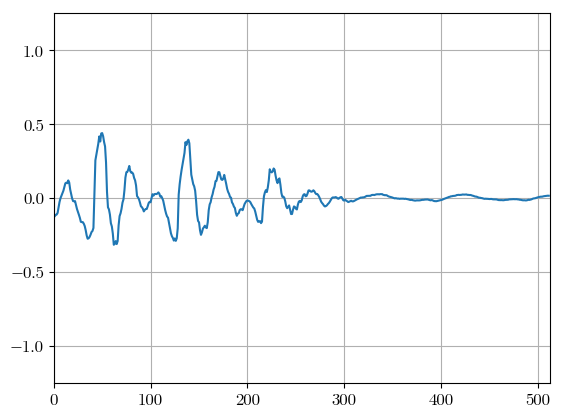

Reconstruction


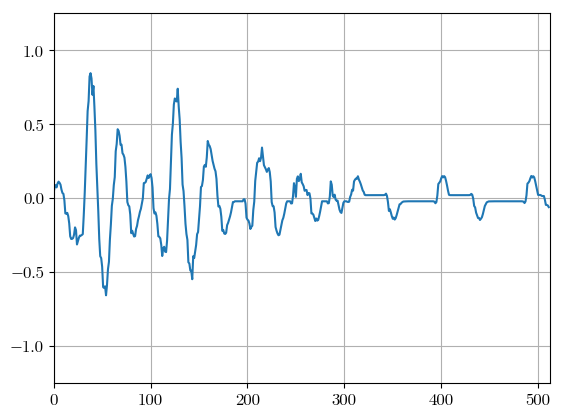

In [12]:
idx = 45

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)

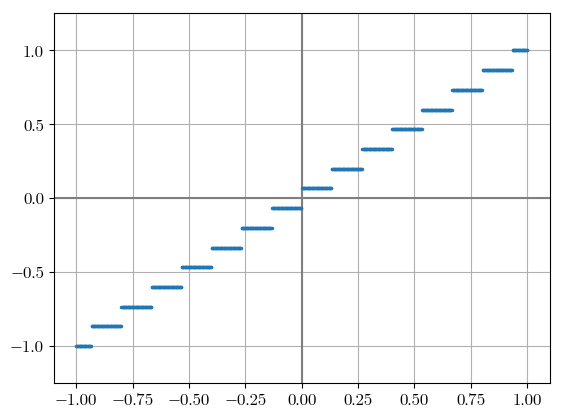

In [13]:
x = np.linspace(-1.0, 1.0, 800)

bins = K.eval(QUANT_BINS)
y = [bins[np.argmin(np.abs(bins - num))] for num in x]
fancy_plot(x, y, dots = True)

## After training

In [14]:
y_train = [X_train] * n_recons + \
          [np.zeros((X_train.shape[0], 1, 1))] * n_code      

model.fit(X_train, y_train, verbose = 1, epochs = 20, batch_size = 128)

Epoch 1/20
101750/101750 [==============================] - 3s - loss: 2.5593 - model_2_loss_1: 0.0253 - model_2_loss_2: 1.6057 - model_1_loss: 0.0387     
Epoch 2/20
101750/101750 [==============================] - 3s - loss: 1.7439 - model_2_loss_1: 0.0114 - model_2_loss_2: 1.1757 - model_1_loss: 0.0453     
Epoch 3/20
101750/101750 [==============================] - 3s - loss: 1.6605 - model_2_loss_1: 0.0113 - model_2_loss_2: 1.0875 - model_1_loss: 0.0469     
Epoch 4/20
101750/101750 [==============================] - 3s - loss: 1.6199 - model_2_loss_1: 0.0113 - model_2_loss_2: 1.0454 - model_1_loss: 0.0470     
Epoch 5/20
101750/101750 [==============================] - 3s - loss: 1.5963 - model_2_loss_1: 0.0113 - model_2_loss_2: 1.0249 - model_1_loss: 0.0463     
Epoch 6/20
101750/101750 [==============================] - 5s - loss: 1.5773 - model_2_loss_1: 0.0114 - model_2_loss_2: 1.0101 - model_1_loss: 0.0453     
Epoch 7/20
101750/101750 [==============================] - 6s -

In [15]:
test_model_on_wav("./SA1.wav", "SA1_quant_after", model, argmax = False)

MSE:         8404.15
Avg err:     41.9541
PESQ:        2.14137172699


[8404.1543, 41.954063, 2.141371726989746]

Original


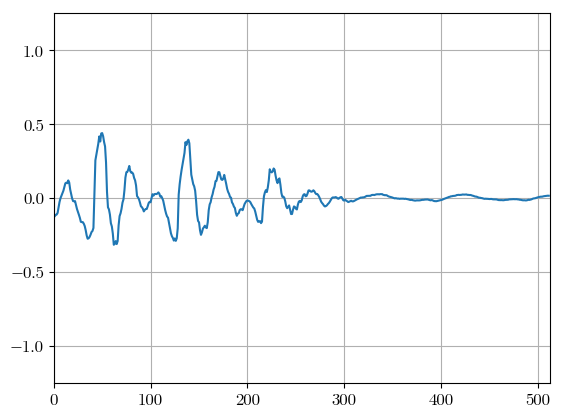

Reconstruction


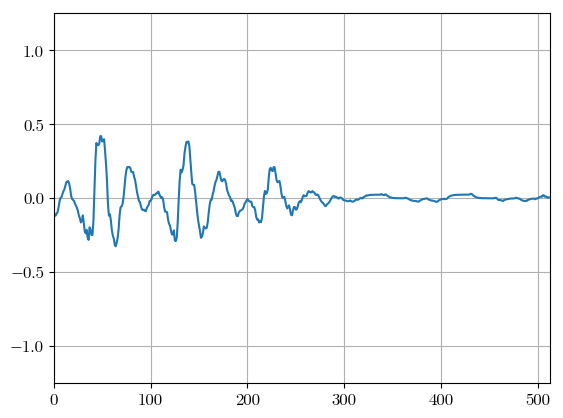

In [16]:
idx = 45

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)

In [17]:
all_embed = enc.predict(X_train[:10000], batch_size = 128, verbose = 0)

probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
hist = np.sum(probs, axis = 0)
hist /= np.sum(hist)

entropy = 0
for i in hist:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print "Entropy of distribution:", entropy

Entropy of distribution: 3.12395708499


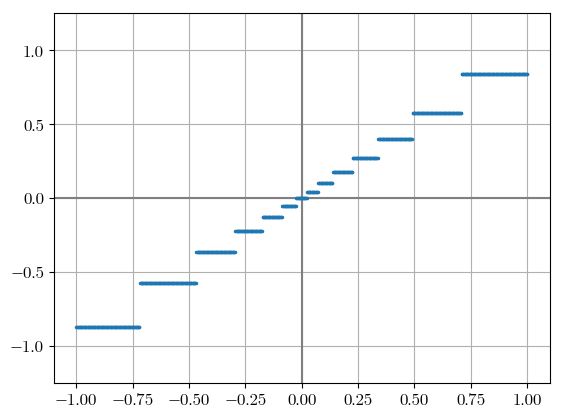

In [18]:
x = np.linspace(-1.0, 1.0, 800)

bins = K.eval(QUANT_BINS)
y = [bins[np.argmin(np.abs(bins - num))] for num in x]
fancy_plot(x, y, dots = True)